# D213 - Advanced Data Analytics Performance Assessment Task 2
Aidan Soares, 012042436, Western Governors University

### A1: Research Question
For this assessment, I am seeking to answer "Can a Neural Network appropriately assess customer sentiment through user reviews?". Customer input is the backbone of satisfaction assessment, general sentiment can be utilized by companies to assess how well a product is doing within a market and grants insights into furhter improvements. For companies looking to garner trial data through user input, they can collect reviews and aggregate positive/negative sentiment to identify specific areas of pain, and overall need for future development. Take for example a trial run for a new game controller; if general sentiment tends towards negativity, the company can recognize that the current product doesn't mesh well with customers. Individual negative reviews can then be read to identify the exact pain points needed to be remedied. However, in considering aggregate data that doesn't necessarily abide by a scale or a binary yes/no survey output, it would take considerable time and resources to comb through that data manually. As such, a neural network, one that can rapidly assess new information that was built upon observed sentiment, would suit the organizational needs much better.

### A2: Goals
My goals for this performance assessment is to utilize the observed Amazon review data collected to train a model to accurately identify positive or negative sentiment for product reviews purely though text. As the focus of this assessment is product reviews, only the Amazon reviews will be used from the UCI Sentiment Labeled Sentences Data Set.

### A3: Neural Network
The neural network identified for this performance assessment was chosen to be a Recurrent Neural Network (RNN). Recurrent neural networks are ideal for sequential-based data, and are commonly utilized for natural language processing, speech recognition, and language translation. These neural networks and are distinguished by their ability to retain 'memory' in analysis, allowing for sentiment to be assessed throughout the entire length of the review (IBM, n.d.). Take for example a sentence that states "In Italy, I learned many things, how to eat pasta properly, how to dress fashionably, and most importantly, they taught me the language -", humans can easily interpret the next word as "Italian", given the context of being in Italy. However this is an issue that most neural networks struggle with, as they typically utilize the closest surrounding words to make the next prediction. However, a recurrent neural network has the capacity to utilize 'memory' to base its prediction upon terms from the beginnning of the review, allowing it to make an effective prediction. With that in mind, a RNN will be ideal for my analysis.

### B1: Exploratory Data Analysis


In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Embedding, Flatten
from tensorflow.keras.models import Sequential

#importing dataset into a dataframe
df = pd.read_csv('amazon_cells_labelled.txt', sep='\t', header = None, names = ['Review', 'Sentiment'])
df.head()

,Review,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [2]:
#general assessment of null/duplicate values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     1000 non-null   object
 1   Sentiment  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [3]:
#checking for duplicates
df.duplicated().value_counts()

False    990
True      10
dtype: int64

In [4]:
#removing 10 duplicate entries
df.drop_duplicates(inplace=True)

#checking if duplicates still remain
df.duplicated().value_counts()

False    990
dtype: int64

In [5]:
df.shape

(990, 2)

0    497
1    493
Name: Sentiment, dtype: int64

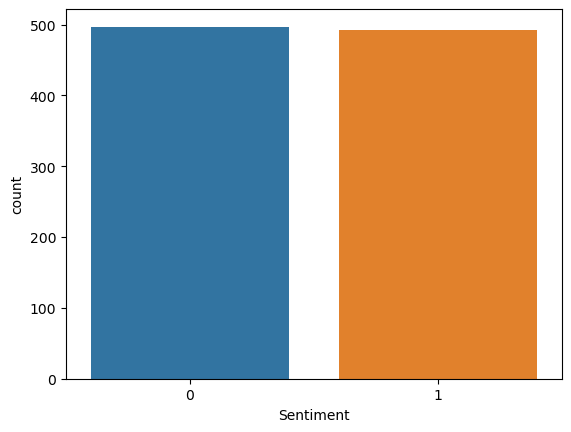

In [6]:
#visualizing the distribution of positive and negative sentiment
sns.countplot(x = "Sentiment", data=df)
df["Sentiment"].value_counts()

In [7]:
#generating list of chars to identify unusual characters/non-english letters
list_of_characters = []
for comment in df.Review:
    for character in comment:
        if character not in list_of_characters:
            list_of_characters.append(character)

list_of_characters.sort()
print(list_of_characters)

[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


**Presence of unusual characters/emojis**

The purpose for the above function is to establish an array of every unique character that can be found within the dataset provided. I have also sorted the array to easily assess any gaps or characters unused from the traditional alphabet/numerical scale. From this we can see that the amazon reviews contain every letter of the alphabet, both capital and lowercase, every number from 0 to 9, and common punctuation terms such as !, ?, ., etc... However, punctuation marks such as the above and #, &, and / do not particularly indicate any form of sentiment. Additionally, while no emojis appear to be present within my list of characters, it is also possible that customers may have utilized characters in conjunction to create some expressions such as :). Therefore, I am going to remove these punctuation marks from my reviews, and I will also re-express all capital letters to lowercase to eliminate redundancy.

In [8]:
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Looking at the list above, these words constitute all the text that bears no sentiment that would indicate a positive or negative review (also known as stopwords). As such, I removed any stopwords from my reviews as they have no relevance to the sentiment analysis. For anyone running this code that does not have a system already equipped with the library for stopwords, simply remove the # comment from the code block above to allow the notebook to download 'stopwords' and 'punkt' to the system.

In [9]:
#make all characters in review lowercase
df["Review"] = df["Review"].str.lower()

#creating empty array to store all reviews that will be re-expressed (Elleh, n.d.)
reviews = []
for text in df["Review"]:
    
    #removing puncuation
    text = re.sub("[^a-zA-Z]", " ", text)
    
    #tokenizing the text in each review
    text = nltk.word_tokenize(text)
    
    #removing stop words from descriptions
    text = [word for word in text if not word in stop_words]
    
    #adding text to the reviews list
    text = " ".join(text)
    reviews.append(text)

In [10]:
#replacing the existing review column in the dataframe with the converted reviews
df["Review"] = reviews

#printing dataframe to see if the changes have been applied
df

,Review,Sentiment
0,way plug us unless go converter,0
1,good case excellent value,1
2,great jawbone,1
3,tied charger conversations lasting minutes maj...,0
4,mic great,1
...,...,...
995,screen get smudged easily touches ear face,0
996,piece junk lose calls phone,0
997,item match picture,0
998,thing disappoint infra red port irda,0


**Vocabulary size**

In [11]:
#identifying the vocabulary size
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["Review"])

vocabulary_size = len(tokenizer.word_index)+1

print("Vocabulary size: ", vocabulary_size)

Vocabulary size:  1690


The vocabulary size (the number of unique words) was determined by tokenizing all the words found across all the reviews, and then by counting the length of the array of tokenized word index.

**Proposed word embedding length**

Per documentation provided by the Tensorflow Team, a good rule of thumb for determining embedding length is to take the 4th root of the vocabulary size (Tensorflow Team, 2017). 

In [12]:
#calculating the 4th root (square root twice) of the vocabulary size
print("The proposed word embedding length is: ", round(vocabulary_size ** 0.25))

The proposed word embedding length is:  6


**Justification for maximum sequence length**

In [13]:
#creating a list of the length of each review
length_sequences = [len(rev) for rev in df["Review"]]

#calculating max, min, and median sequence lengths for all reviews within list of reviews
print("Maximum review sequence length: ", np.max(length_sequences))
print("Minimum review sequence length: ", np.min(length_sequences))
print("Median review sequence length: ", np.median(length_sequences))

mseq_length = np.max(length_sequences)

Maximum review sequence length:  114
Minimum review sequence length:  3
Median review sequence length:  29.0


Based on the statistical review of the sequence lengths above, the maximum sequence length of 114 words will be used to pad sequences shorter than this amount.

### B2: Tokenization Goals
The tokenization performed within this performance assessment is a process by which words are converted into an index based on the amount of times it appears within the dataset. Within the cleaning stage above, unnecessary symbols, punctuation marks, and text that does not carry any sentiment were removed. I then converted all the text within the reviews to lowercase as tokenization is case sensitive. The code for this was conducted in section B1.

Now, the next stage of tokenization is to split the cleaned dataframe into training, validation, and testing sets with sklearn's train_test_split function. In researching the ideal split parameters, there is no defined 'optimal' splitting ratio for these datasets, it has instead been recommended to split based on the quantity of data available to analyze to ensure that each dataset provides enough information for the model to train on (Baheit, 2021). As the cleaned dataset contains 990 reviews for analysis, I am proposing to divide the data at a 70% train, 15% validation, and 15% test split to feed to my tensorflow model. These sets will then be tokenized prior to the padding process. 

In [14]:
#splitting the data into a training set at 70%, reserving the other 30% for another split into validation and test sets
X_train, X_reserve, y_train, y_reserve = train_test_split(df.Review, df.Sentiment, train_size = 0.7, random_state = 42)

#splitting the reserve data into validation and testing sets at 50% (a total of 15% each from the original dataset)
X_val, X_test, y_val, y_test = train_test_split(X_reserve, y_reserve, train_size = 0.5, random_state = 42)

#confirmation of size for split sample sets
print("Training set length:", X_train.shape[0])
print("Validation set length:", X_val.shape[0])
print("Testing set length:", X_test.shape[0])

Training set length: 693
Validation set length: 148
Testing set length: 149


In [15]:
#tokenizing the split data
token_train = tokenizer.texts_to_sequences(X_train)
token_val = tokenizer.texts_to_sequences(X_val)
token_test = tokenizer.texts_to_sequences(X_test)

token_train[0]

[46, 1302, 199, 1303, 161, 141, 1304, 228, 1, 21, 173, 19]

### B3: Padding Process
As calculated in section B1, the maximum sequence length found within my cleaned dataset was 114 words long. As such, I will pad out all of the sequences within the X training and testing sets to match a total 114. This process adds 0 for any sequence that is below the maximum (114) so that all the sequences will be the same length, which will optimize the performance of the tensorflow model. For this process, I have set the padding to occur *after* the existing text sequence by setting the padding parameter to 'post'. Padding only needs to be done on the set of X data, as y data is purely a binary sentiment category. An example of a padded sequence will be printed after the padding process is completed, showing a comparison to the original token_train[0] above.

In [16]:
#padding the training and test data, setting max sequence length to 114 and padding after the text sequence
pad_train = pad_sequences(token_train, mseq_length, padding = 'post')
pad_val = pad_sequences(token_val, mseq_length, padding = 'post')
pad_test = pad_sequences(token_test, mseq_length, padding = 'post')

pad_train[0]

array([  46, 1302,  199, 1303,  161,  141, 1304,  228,    1,   21,  173,
         19,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0])

As can be seen from the above, the new sequence at index 0 in the training set has been padded to match the 114 maximum length.

### B4: Sentiment Categories
There are 2 categories of sentiment within my data; a positive sentiment (expressed as 1), and negative sentiment (expressed as 0).

The activation function utilized for the final layer of the network will be sigmoid (also referred to as logistic function). The sigmoid function was chosen as it maps outputs to a range between 0 and 1 only (Brownlee, 2021), fitting perfectly with the conditions of our sentiment categories.

### B5: Data Preparation Steps
1. Extract the review data within the amazon_cells_labelled text document, storing it in a dataframe with two columns: Review and Sentiment
2. Review dataframe for null values and duplicate entries, removing any nulls and duplicates found.
3. List all characters within review dataset to identify presence of emoji's, non-english characters, etc...
4. Identify all stopwords within review dataset
5. Convert all text in reviews to lowercase, remove punctuation, non-english characters, emojis, and stopwords, cleaning all data in the review dataframe
6. Tokenize all text within reviews using fit_on_texts functions, converting words to numerical index for mathematical operations
7. Identify the max length of all sequences within the data for padding number
8. Split data into training, validation, and test sets at a 70%, 15%, 15% split respectively. NOTE*
9. Tokenize the Review portions of the training, validation, and testing sets using texts_to_sequences
10. Pad all tokenized sequences using the max length identified from the max sequence length, and set padding to 'post'

NOTE*: as discussed within section B2, data was chosen to be split into train, validation, and test sets at 70%, 15%, and 15% respectively as industry practice recommends having a large enough validation set for the model to use for assessment, so it will be no smaller than 15%.

### B6: Prepared Dataset
I will provide the tokenized/padded training, validation, and testing sets seperately below.

In [17]:
#exporting cleaned dataset to csv
pd.DataFrame(pad_train).to_csv('pad_train.csv')
pd.DataFrame(pad_val).to_csv('pad_val.csv')
pd.DataFrame(pad_test).to_csv('pad_test.csv')
pd.DataFrame(y_train).to_csv('y_train.csv')
pd.DataFrame(y_val).to_csv('y_val.csv')
pd.DataFrame(y_test).to_csv('y_test.csv')

### C1: TensorFlow Model Output

In [18]:
#creating the sequential model (Tensorflow, 2020)
model = Sequential()
model.add(Embedding(vocabulary_size, round(vocabulary_size ** 0.25)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#fitting the model
history = model.fit(pad_train, y_train, batch_size=32, epochs = 20, 
                  validation_data = (pad_val, y_val), callbacks=[EarlyStopping(patience=2)], 
                    verbose = True)

#printing model summary
model.summary()

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5026 - loss: 0.6947 - val_accuracy: 0.4932 - val_loss: 0.6935
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5150 - loss: 0.6907 - val_accuracy: 0.5000 - val_loss: 0.6902
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5571 - loss: 0.6829 - val_accuracy: 0.6419 - val_loss: 0.6819
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7768 - loss: 0.6604 - val_accuracy: 0.6216 - val_loss: 0.6647
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7088 - loss: 0.6135 - val_accuracy: 0.7905 - val_loss: 0.6237
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9332 - loss: 0.5228 - val_accuracy: 0.7230 - val_loss: 0.5704
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9489 - loss: 0.3954 - val_accuracy: 0.6757 - val_loss: 0.5460
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9689 - loss: 0.2874 - val_accuracy: 0.7838 - val_loss:

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 114, 6)         │        10,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 684)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        34,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,325 (520.80 KB)

 Trainable params: 44,441 (173.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,884 (347.21 KB)

### C2: Layer Discussion
For the sequential model above, 4 layers were used.
- The first layer is an **embedding** layer, establishing the vocabulary size, embedding length of 6, and an implicit maximum sequence length of 114.
- The second layer is a **flattening** layer to reduce the dimensionality of the dataset to increase performance and efficiency. There are no parameters assigned to this layer.
- The third layer used is a **dense** layer consiting of 50 nodes, this amount was chosen based on suggestion from the course instructor in the educational material (Elleh, n.d.). The activation function for this layer is a ReLU function, which is a function that converts negative inputs into positive outputs to reduce linearity in the model, boosting performance (Brownlee, 2020).
- The fourth and final layer is another **dense** layer, containing a single output node (the sentiment output). This layer utilizes the sigmoid function as its activation function, which outputs a binary outcome of either positive (1) or negative (0) sentiment.

The total number of parameters for the model is 133,325. Of this amount, 44,441 are trainable parameters, while 88,884 are optimizer parameters.

### C3: Hyperparameter Selection
- **Activation functions:** For the first dense layer, ReLU (rectified linear activation function) was chosen as the activation function as it reduces the linearity of the data, making patterns more complex. This allows for more unique relationships to be identified by the model so it increases the performance. The second dense layer utilizes a sigmoid activation function. The benefit of this function provides an output of either positive (1), or negative (0), aligning perfectly with the desired prediction of our sentiment analysis model.
- **Nodes per layer:** As stated above, the first dense layer consisted of 50 nodes, this amount was chosen based on suggestion from the course instructor in the course materials (Elleh, n.d.). The second dense layer only had 1 node, as the aim was to return a single binary output for the sentiment.
- **Loss function:** Cross-entropy was utilized as the loss function. It is used to assess performance in deep learning models by minimizing errors between actual and predicted outcomes. *Binary* Cross-Entropy was selected as it is meant to be utilized in binary classification, such as the prediction of positive and negative sentiment (Pykes, 2024).
- **Optimizer:** The optimizer chosen for this model is known as Adam. It is an optimization algorithm designed to evaluate prediction parameters to achieve an ideal accuracy in a deep learning model. It was selected as it is straightforward to implement and very computationally efficient, allowing for better performance and efficient runtimes of code (Brownlee, 2021).
- **Stopping criteria:** The stopping criteria is a parameter that identifies the point at which the model should stop iterating on a training dataset to prevent overfitting of data. In the application of a model, the stopping criteria is a set value that monitors and stops the model from training when the validation accuracy lowers in successive epochs. In the case of my model, I set an early stopping criteria with a Patience of 2 epochs so that the iteration process of my model would immediately halt before it began overfitting on the training data. 
- **Evaluation metric:** The evaluation metric used for this model was of course the accuracy of predictions. This was chosen as the aim of this assessment is to determine the predictive accuracy of my model in sentiment analysis. As such, this parameter establishes the aim of maximizing the accuracy of the model until either all the epochs have run or the stopping criteria terminates the training process.

### D1: Stopping Criteria
The established stopping criteria with a patience of 2 Epochs terminated the process of fitting my model early as seen in section C1. Overall, while I established a maximum of 20 epochs, the fitting of my model terminated at epoch 13 due to the stopping criteria. To see the termination please refer to the output for section C1 above but I have also copied it below:

Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0654 - val_accuracy: 0.7635 - val_loss: 0.4882

### D2: Fitness of the Model

In [32]:
#printing the accuracy score of the model fit on training data
a_score = model.evaluate(pad_train, y_train, verbose=0)
print("Overall training loss:", a_score[0], "\nOverall accuracy score:", round(a_score[1]*100, 2),"%")

Overall training loss: 0.05876835063099861 
Overall accuracy score: 99.28 %


In [33]:
#printing the accuracy score of the model fit on testing data that it has not seen before
b_score = model.evaluate(pad_test, y_test, verbose=0)
print("Overall testing loss:", b_score[0], "\nOverall accuracy score:", round(b_score[1]*100, 2),"%")

Overall testing loss: 0.4799564480781555 
Overall accuracy score: 79.87 %


As can be seen from the calculations above, the model sports a *very* solid predictive accuracy for customer sentiment at 99%, with a very low loss value of 0.06 with *training* data. Of course, this is an expected outcome as the model was trained on this data, I would expect it to have great predictive accuracy with it.

In contrast, when fit on data it has not seen before (test data), the model yields an accuracy of roughly 80% and loss value of 0.48. What this tells us is that the model has overfit on the training data, and it has difficulty in predicting on data it has not seen before. Within the model training process, I utilized a stopping criteria of 2 epochs in an attempt to prevent overfitting training data at the earliest epoch, however the model's predictive accuracy on new data still remains a bit weaker than that of the training data.

### D3: Visualization of Training process

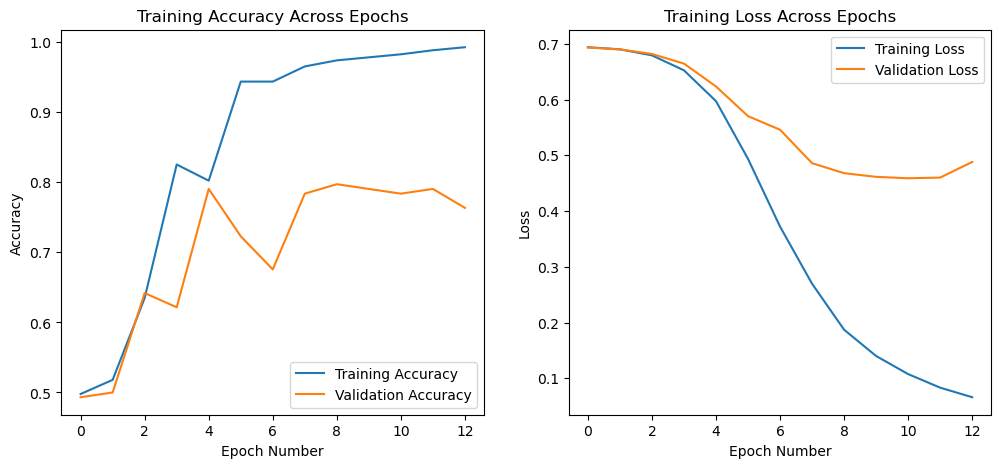

In [21]:
#visualizations for training process
plt.figure(figsize = [12,5])

#plot 1: Training Accuracy 
plt.subplot(1, 2, 1)
plt.title("Training Accuracy Across Epochs")
plt.plot(history.history['accuracy'], label = "Training Accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.legend()

#plot 2: Loss of Training
plt.subplot(1, 2, 2)
plt.title("Training Loss Across Epochs")
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()

plt.show()

As can be seen from the graphs above, the chosen evaluation metrics for the performance of my model visualized are the training accuracy against validation accuracy, and the training loss against the validation loss.

### D4: Predictive Accuracy
To reiterate on the calculations performed in section D2, the accuracy & loss data across my model is:
- 99% accurate, with loss value of 0.06 for the *training* data
- 80% accurate, with loss value of 0.48 for the *testing* data

It is known that the model has overfit a bit on the training data, which makes the accuracy of predictions on new, unseen data less accurate than the information that it is comfortable with. Furthermore, looking at the loss value of 0.48 within the testing data, this means the model is not very confident in the predictions it makes. However, while not as spectacular as its predictive accuracy on the training data, the model still demonstrates a modest ability to predict correct customer sentiment on new data as evidenced by the decent accuracy score when evaluating on the test dataset.

### E: Training Code

In [22]:
#Code used to save model for later use if needed
#I received a warning from the program that HDF5 files are now legacy and that I should instead save the model in .keras
#format instead
model.save("task2_model.keras")

### F: Neural Network Functionality
The model created is a Recurrent Neural Network that was training to identify sentiment of customer satisfaction on products tested and purchased from Amazon. It has trained on a total of 693 user reviews alongside the binary sentiment to create a model that can predict the positive or negative status of a customer's review purely from text. 

The impact of the network architecture has significant to achieving solid predictive accuracy in the model. Said architecture involved optimization to establish the appropriate layers necessary for the model to achieve solid performance through the ideal parameters chosen for layering a binary output, choosing the appropriate activation functions, establishing appropriate node count, loss function, optimization algorithm, evaluating accuracy during training, and setting stopping criteria in order to result in a relatively high prediction accuracy on the unseen testing data.

Overall, this network has achieved the goal established within the research question of this performance assessment as it's testing accuracy of 80% has the appropriate predictive accuracy to deem it usable in a testing environment with new unseen data. Thus, the model shows suitability in use for sentiment analysis

### G: Recommendation
Given the predictive accuracy of the model on unseen data, I do recommend for it to be used in a business environment to quickly assess customer sentiment of new product runs. The use of this model could significantly aide in the analysis of customer feedback without the necessity of long surveys or using a rating system, and can be applied at scale for synthesis of evaulation metrics, identifying areas of improvement and significant business needs. In the evaluation of product improvements, analysts can pull from reviews classified with a negative sentiment to isolate specific pain points, allowing for the identification and remediation of friction with user experience.

### H: Development Environment
The entirety of this performance assessment was conducted within the Jupyter Notebook interactive development environment, allowing for a structured breakdown of both my code and written notes. I will provide the completed ipynb file alongside an executed HTML document within my final submission.

### I: Code Sources
Elleh, Festus. n.d. *Task 2 Data Preprocessing Python*. Western Governors University. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=8639374a-964b-4ae9-b33b-b1210052c07d

Elleh, Festus. n.d. *Building NN Model in Python*. Western Governors University. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=1b9aff54-735f-456a-a6b4-b11b00eb8d2f



### J: Sources
IBM. n.d. *What are Recurrent Neural Networks?* IBM. https://www.ibm.com/topics/recurrent-neural-networks

Tensorflow Team. November 20, 2017. *Introducing TensorFlow Feature Columns*. Google for Developers. https://developers.googleblog.com/en/introducing-tensorflow-feature-columns/

Brownlee, Jason. January 22, 2021. *How to Choose an Activation Function for Deep Learning*. Machine Learning Mastery. https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

Brownlee, Jason. August 20, 2020. *A Gentle Introduction to the Rectified Linear Unit (ReLU)*. Machine Learning Mastery. https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

Brownlee, Jason. January 13, 2021. *Gentle Introduction to the Adam Optimization Algorithm for Deep Learning*. Machine Learning Mastery. https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

Baheti, Pragati. September 13, 2021. *Train Test Validation Split: How To & Best Practices [2024]*. V7. https://www.v7labs.com/blog/train-validation-test-set

Pykes, Kurtis. January 2024. *Cross-Entropy Loss Function in Machine Learning: Enhancing Model Accuracy*. Datacamp. https://www.datacamp.com/tutorial/the-cross-entropy-loss-function-in-machine-learning